In [4]:
# matplotlib 显示中文
import matplotlib.pyplot as plt

# 设置matplotlib支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [5]:
import os
import torch
import numpy as np
from PIL import Image

In [6]:
def visualize_results(images, image_paths, texts_zh, texts_en, probs_zh, probs_en):
    """可视化CLIP匹配结果，中英文并排显示"""
    n_images = len(images)
    n_texts = len(texts_zh)
    
    # 创建足够大的图形
    plt.figure(figsize=(24, 7 * n_images))

    for i in range(n_images):
        # 显示图像
        plt.subplot(n_images, 3, i*3+1)
        plt.imshow(images[i])
        plt.title(f"图像 {i+1}: {os.path.basename(image_paths[i])}")
        plt.axis('off')
        
        # 显示中文匹配概率条形图
        probs_data_zh = probs_zh[i].cpu().detach().numpy()
        plt.subplot(n_images, 3, i*3+2)
        y_pos = np.arange(n_texts)
        plt.barh(y_pos, probs_data_zh)
        plt.yticks(y_pos, texts_zh)
        plt.xlabel('匹配概率')
        plt.title(f'图像 {i+1} 的中文文本匹配概率')
        
        # 查找中文最高概率的文本
        best_match_idx_zh = torch.argmax(probs_zh[i]).item()
        plt.plot([0, probs_data_zh[best_match_idx_zh]], [best_match_idx_zh, best_match_idx_zh], 
                 'r', linewidth=2)
        
        # 显示英文匹配概率条形图
        probs_data_en = probs_en[i].cpu().detach().numpy()
        plt.subplot(n_images, 3, i*3+3)
        plt.barh(y_pos, probs_data_en)
        plt.yticks(y_pos, texts_en)
        plt.xlabel('Matching Probability')
        plt.title(f'Image {i+1} Text Matching Probability (English)')
        
        # 查找英文最高概率的文本
        best_match_idx_en = torch.argmax(probs_en[i]).item()
        plt.plot([0, probs_data_en[best_match_idx_en]], [best_match_idx_en, best_match_idx_en], 
                 'r', linewidth=2)
        
    plt.tight_layout()
    # plt.savefig('./clip_results_bilingual.png', dpi=150, bbox_inches='tight')
    # print("可视化结果已保存到 clip_results_bilingual.png")
    plt.show()

In [93]:
def load_image_from_path(image_path):
    """从本地路径加载图片"""
    if os.path.exists(image_path):
        return Image.open(image_path).convert('RGB')
    else:
        print(f"警告：无法找到图像文件 {image_path}")
        return None

def main(model, processor):
    # 准备示例图片路径
    image_paths = [
        "./images/打篮球_二次元.jpeg",
        "./images/两只猫.jpg",
        "./images/玫瑰花.png",
        "./images/皮卡丘.jpeg",
    ]

    # 加载图像
    images = []
    for path in image_paths:
        img = load_image_from_path(path)
        if img:
            images.append(img)

    if not images:
        print("错误：没有找到任何有效的图像文件")

    # 准备文本描述
    # ! max_length=16，中文必须简短
    texts_zh = [
        "一只猫",
        "两只猫",
        "一只狗",
        "一只皮卡丘",
        "一只宝可梦",
        "一个篮球",
        "一朵玫瑰",
        "一辆车",
        "一只兔子",
        "一个钢琴"
    ]

    texts_en = [
        "This is a photo of a cat",
        "This is a photo of 2 cats",
        "This is a photo of a dog",
        "This is a photo of a pikachu",
        "This is a photo of a pokemon",
        "This is a photo of a basketball",
        "This is a photo of a rose",
        "This is a photo of a car",
        "This is a photo of a rabbit",
        "This is a photo of a piano"
    ]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print("处理中文和英文文本...")
    with torch.no_grad(): 
        try:
            # padding="max_length" 表示将文本填充到最大长度。
            # ! important: we pass `padding=max_length` since the model was trained with this
            # ! 切记，padding必须设置为max_length，否则会导致结果极差
            inputs_zh = processor(images=images, text=texts_zh, return_tensors="pt", padding="max_length", truncation=True).to(device)
            outputs_zh = model(**inputs_zh)
            logits_per_image_zh = outputs_zh.logits_per_image
            probs_zh = torch.sigmoid(logits_per_image_zh)
            
            # 处理英文文本
            inputs_en = processor(images=images, text=texts_en, return_tensors="pt", padding="max_length", truncation=True).to(device)
            outputs_en = model(**inputs_en)
            logits_per_image_en = outputs_en.logits_per_image
            probs_en = torch.sigmoid(logits_per_image_en)

            # 使用matplotlib可视化结果
            visualize_results(images, image_paths, texts_zh, texts_en, probs_zh, probs_en)
        
        except Exception as e:
            print(f"处理数据时发生错误: {str(e)}")
            import traceback
            traceback.print_exc()


In [88]:
from transformers import AutoProcessor, AutoModel
from transformers import SiglipProcessor, SiglipModel

# 加载CLIP模型和处理器
print("正在加载SigLIP模型...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SiglipModel.from_pretrained("google/siglip-so400m-patch14-224").to(device)
processor = SiglipProcessor.from_pretrained("google/siglip-so400m-patch14-224")

# 支持的模型：https://huggingface.co/openai
# 1. google/siglip-base-patch16-224
# 2. google/siglip-base-patch16-256
# 3. google/siglip-base-patch16-256-multilingual
# 4. google/siglip-base-patch16-384
# 5. google/siglip-base-patch16-512
# 6. google/siglip-so400m-patch16-256-i18n
# 7. google/siglip-so400m-patch14-224
# 8. google/siglip-so400m-patch14-384
# 9. google/siglip-large-patch16-256
# 10. google/siglip-large-patch16-384

正在加载SigLIP模型...


In [89]:
# 定义要分词的文本
text = "一只可爱的橘猫"
# 使用处理器的分词器进行分词
inputs = processor.tokenizer(text, return_tensors="pt")
# 获取分词后的输入 ID
input_ids = inputs["input_ids"].squeeze()
# 将输入 ID 转换为分词结果
tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

text = "a cute orange cat"
inputs = processor.tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"].squeeze()
tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (23 > 16). Running this sequence through the model will result in indexing errors


['▁', '<0xE4>', '<0xB8>', '<0x80>', '<0xE5>', '<0x8F>', '<0xAA>', '<0xE5>', '<0x8F>', '<0xAF>', '<0xE7>', '<0x88>', '<0xB1>', '<0xE7>', '<0x9A>', '<0x84>', '<0xE6>', '<0xA9>', '<0x98>', '<0xE7>', '<0x8C>', '<0xAB>', '</s>']
['▁', 'a', '▁cute', '▁orange', '▁cat', '</s>']


In [90]:
print(f"模型路径: {model.config._name_or_path}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")
print(f"词表大小: {model.config.text_config.vocab_size}")
print(f"文本塔的最大序列长度: {model.config.text_config.max_position_embeddings}")

模型路径: google/siglip-so400m-patch14-224
模型参数量: 877.36M
词表大小: 32000
文本塔的最大序列长度: 16


处理中文和英文文本...


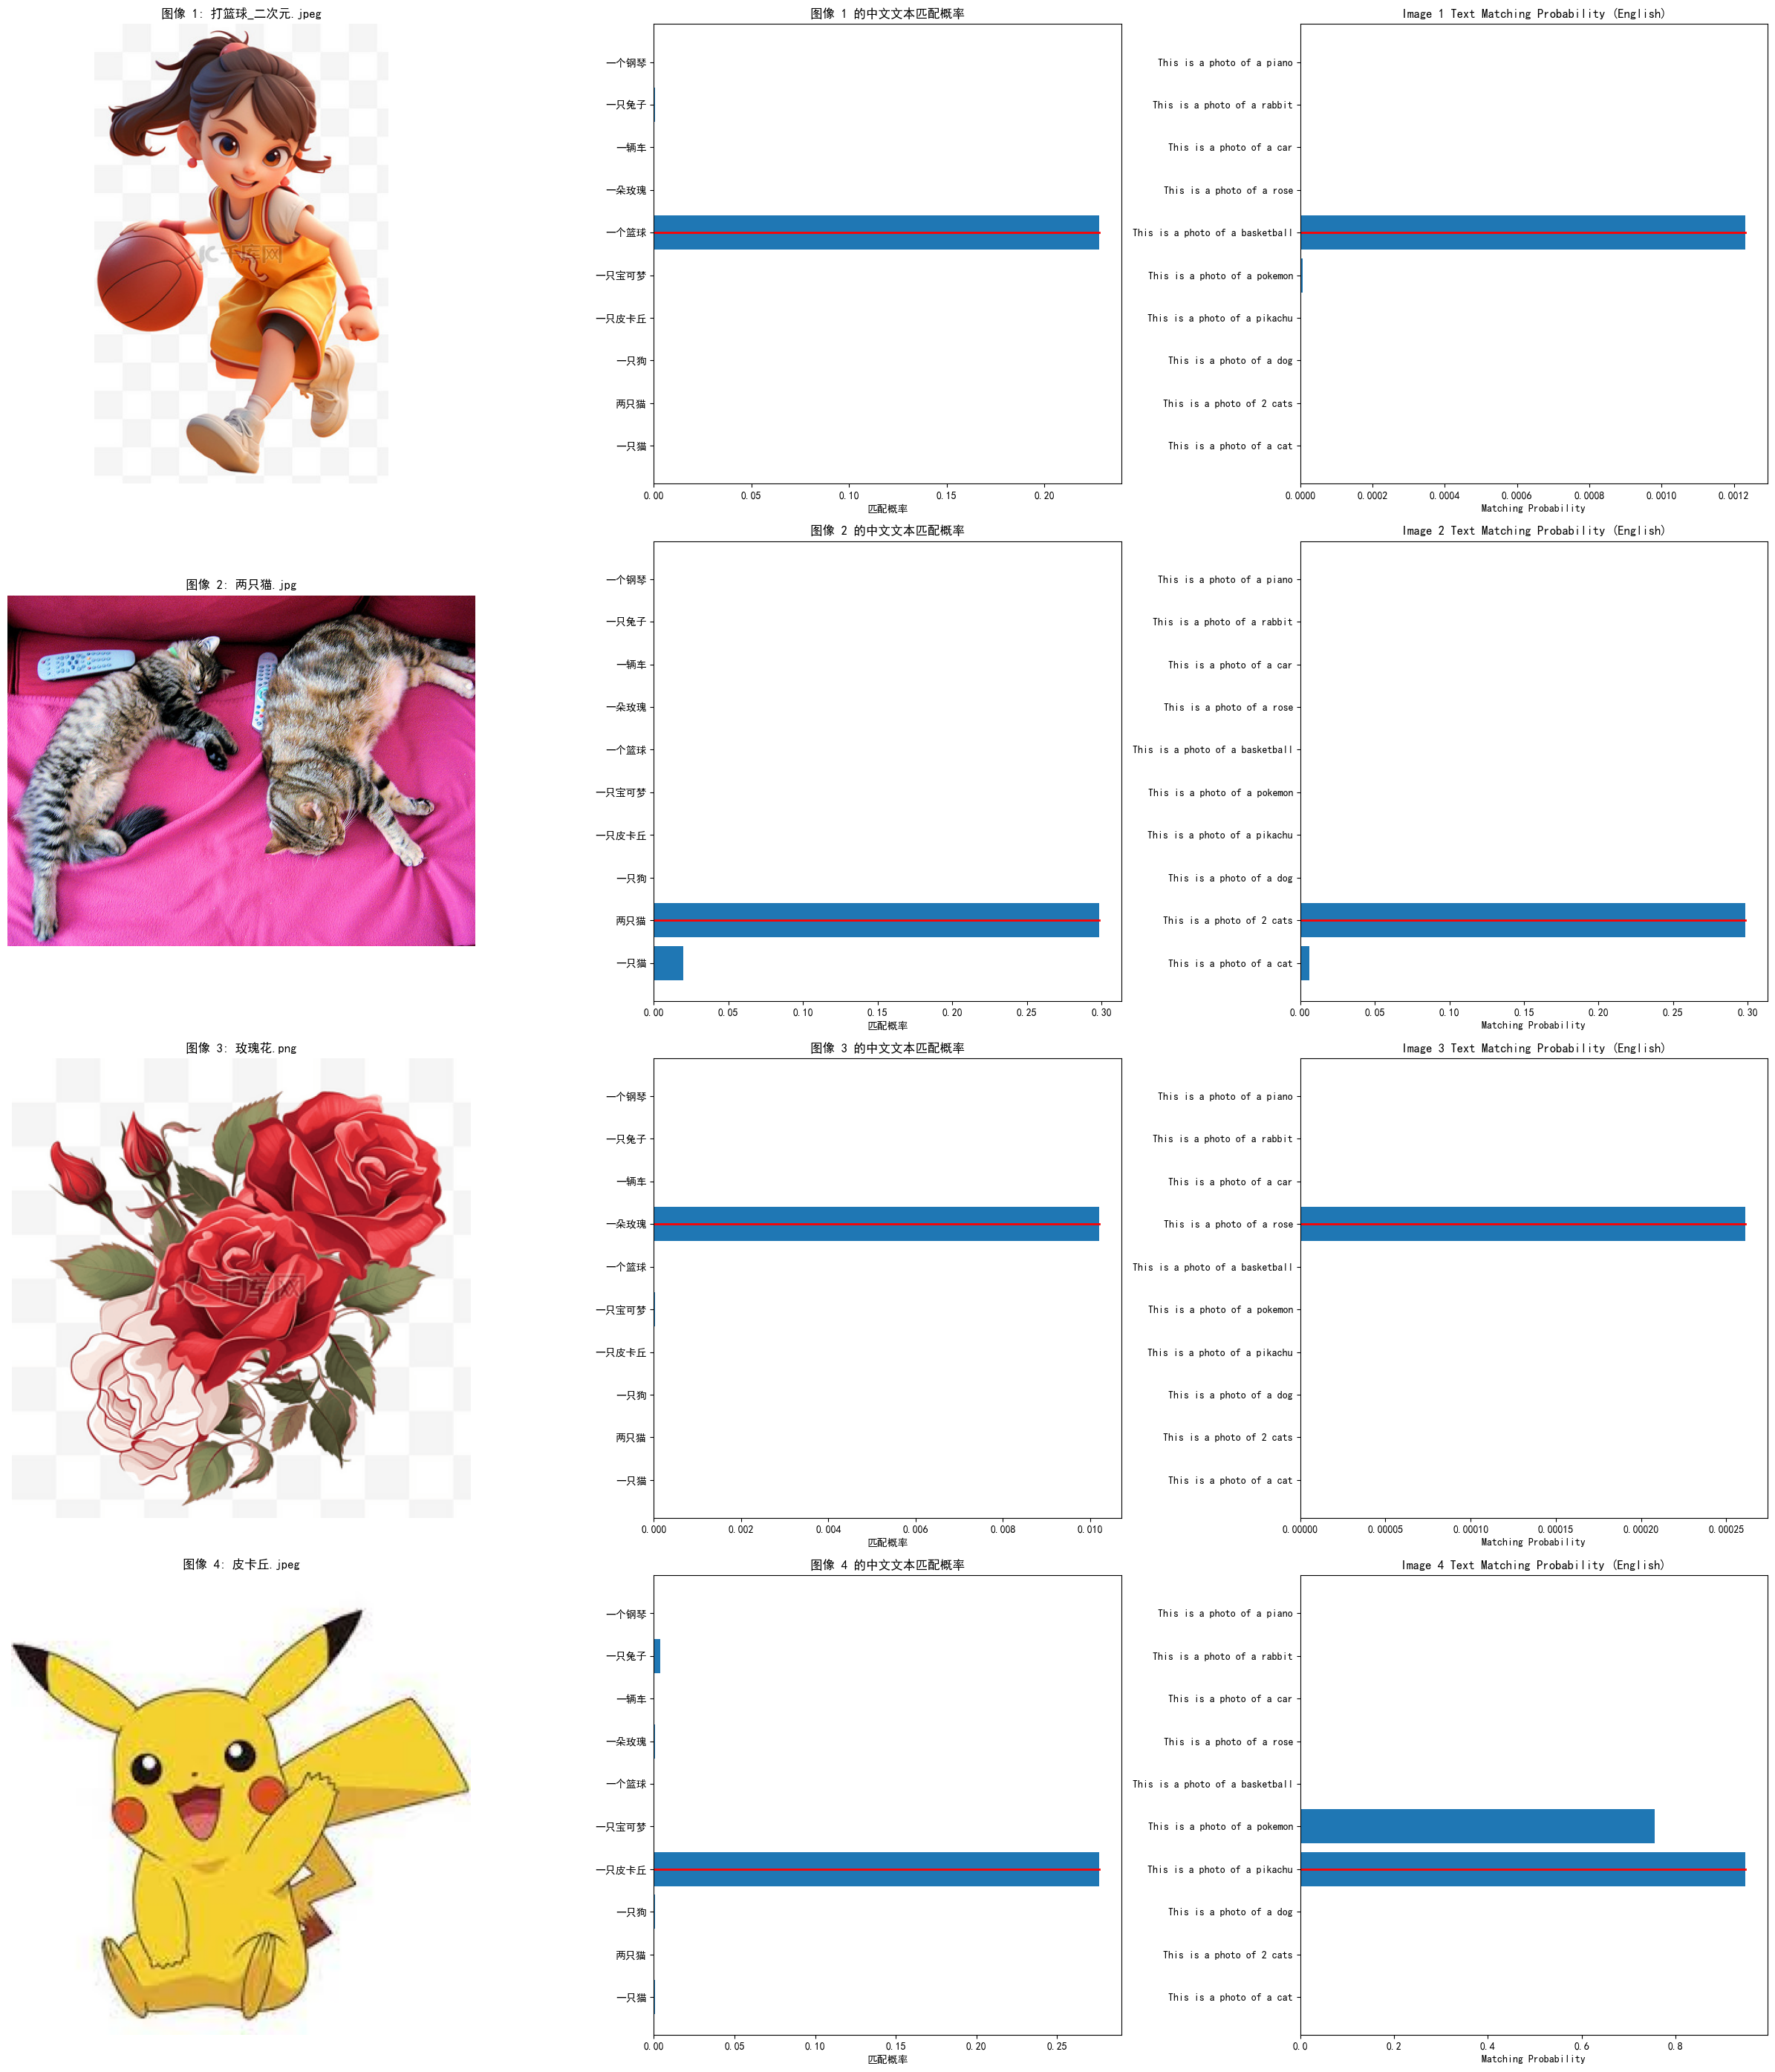

In [94]:
main(model, processor)

In [95]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-256-multilingual").to(device)
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-256-multilingual")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

candidate_labels = ["2 cats", "2 dogs"]
# texts = [f'This is a photo of {label}.' for label in candidate_labels]
texts = ['This is a photo of 2 cats.', 'This is a photo of 2 dogs.']
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{candidate_labels[0]}'")

21.6% that image 0 is '2 cats'


### 使用flash attention2

In [6]:
# 是否使用Flash Attention
try:
    from flash_attn import flash_attn_func
    print("Flash Attention 2支持已启用！")
except ImportError:
    print("未找到flash-attn库，请先安装。")

Flash Attention 2支持已启用！


In [3]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# siglip支持Flash Attention 2，参考：https://github.com/huggingface/transformers/blob/main/docs/source/en/model_doc/siglip.md
model = AutoModel.from_pretrained(
    "google/siglip-so400m-patch14-224",
    attn_implementation="flash_attention_2", # "sdpa" # PyTorch 包含一个原生的缩放点积注意 (scaled dot-product attention, SDPA) 运算符，作为 torch.nn.functional functional 的一部分
    torch_dtype=torch.bfloat16, # torch.float16
    device_map=device)
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-224")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
if image.mode in ['RGBA', 'LA']: 
    image = image.convert('RGB')
pixel_tensors = processor(images=image, return_tensors="pt")['pixel_values'].to(device)
print(pixel_tensors.shape) # torch.Size([1, 3, 224, 224])
with torch.no_grad():
    with torch.autocast(device):
        outputs = model.vision_model(pixel_values=pixel_tensors)

print(outputs.last_hidden_state.shape) # torch.Size([1, 256, 1152])
# ! 没有CLS token
img_embedding = outputs.last_hidden_state.squeeze()
print(img_embedding.shape) # torch.Size([256, 1152])

torch.Size([1, 3, 224, 224])
torch.Size([1, 256, 1152])
torch.Size([256, 1152])


~/.cache/huggingface/hub/models--google--siglip-so400m-patch14-224/snapshots/d04cf29fca7b6374f74d8bea1969314492266b5e/tokenizer_config.json

```json
{
  "added_tokens_decoder": {
    "1": {
      "content": "</s>",
      "lstrip": true,
      "normalized": false,
      "rstrip": true,
      "single_word": false,
      "special": true
    },
    "2": {
      "content": "<unk>",
      "lstrip": true,
      "normalized": false,
      "rstrip": true,
      "single_word": false,
      "special": true
    }
  },
  "additional_special_tokens": [],
  "clean_up_tokenization_spaces": true,
  "do_lower_case": true,
  "eos_token": "</s>",
  "model_input_names": [
    "input_ids"
  ],
  "model_max_length": 16,
  "pad_token": "</s>",
  "processor_class": "SiglipProcessor",
  "sp_model_kwargs": {},
  "tokenizer_class": "SiglipTokenizer",
  "unk_token": "<unk>"
}
```

config.json
```json
{
  "architectures": [
    "SiglipModel"
  ],
  "initializer_factor": 1.0,
  "model_type": "siglip",
  "text_config": {
    "hidden_size": 1152,
    "intermediate_size": 4304,
    "max_position_embeddings": 16,
    "model_type": "siglip_text_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 27
  },
  "torch_dtype": "float32",
  "transformers_version": "4.45.0.dev0",
  "vision_config": {
    "hidden_size": 1152,
    "intermediate_size": 4304,
    "model_type": "siglip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 27,
    "patch_size": 14
  }
}
```

! git clone https://huggingface.co/google/siglip-so400m-patch14-224